In [3]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("PART 1\n")


df = pd.read_csv('/content/drive/MyDrive/HW1_var_7.csv', sep=';', encoding='utf-8')
print("Data shape:", df.shape)

print(df.info())
print(df.head())
print(df.describe(include='all'))

PART 1

Data shape: (10243, 44)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10243 entries, 0 to 10242
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Номер варианта         10243 non-null  int64  
 1   ID                     10243 non-null  int64  
 2   INCOME_BASE_TYPE       10180 non-null  object 
 3   CREDIT_PURPOSE         10243 non-null  object 
 4   INSURANCE_FLAG         10243 non-null  int64  
 5   DTI                    10120 non-null  float64
 6   SEX                    10243 non-null  object 
 7   FULL_AGE_CHILD_NUMBER  10243 non-null  int64  
 8   DEPENDANT_NUMBER       10243 non-null  int64  
 9   EDUCATION              10243 non-null  object 
 10  EMPL_TYPE              10232 non-null  object 
 11  EMPL_SIZE              10121 non-null  object 
 12  BANKACCOUNT_FLAG       7908 non-null   float64
 13  Period_at_work         7906 non-null   float64
 14  age                   

In [5]:
missing_data = pd.DataFrame({
    'Number of gaps': df.isnull().sum(),
    'Percentage of gaps': (df.isnull().sum() / len(df)) * 100
})
print(missing_data.sort_values('Percentage of gaps', ascending=False))

unique_zeros_analysis = pd.DataFrame({
    'Unique values': df.nunique(),
    'Number of zeroes': (df == 0).sum(),
    'Percentage of zeroes': ((df == 0).sum() / len(df)) * 100
})
print(unique_zeros_analysis)

                       Number of gaps  Percentage of gaps
avg_num_delay                    6655           64.971200
all_credits                      6641           64.834521
own_closed                       6641           64.834521
Active_not_cc                    6641           64.834521
max_MnthAfterLoan                6641           64.834521
dlq_exist                        6641           64.834521
thirty_in_a_year                 6641           64.834521
num_AccountActive60              6641           64.834521
num_AccountActive180             6641           64.834521
num_AccountActive90              6641           64.834521
if_zalog                         6641           64.834521
min_MnthAfterLoan                6641           64.834521
ninety_in_a_year                 6641           64.834521
thirty_vintage                   6641           64.834521
sixty_vintage                    6641           64.834521
sixty_in_a_year                  6641           64.834521
ninety_vintage

In [6]:
low_missing_columns = [
    'ID', 'INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'DTI',
    'SEX', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'EDUCATION',
    'EMPL_TYPE', 'EMPL_SIZE'
]

df_for_segmentation = df[low_missing_columns].copy()
print(f"Start size: {df_for_segmentation.shape}")

print("\nGaps befor preprocessing:")
print(df_for_segmentation.isnull().sum())

df_for_segmentation['INCOME_BASE_TYPE'].fillna('Не указано', inplace=True)
df_for_segmentation['EMPL_TYPE'].fillna('Не указано', inplace=True)
df_for_segmentation['EMPL_SIZE'].fillna('Не указано', inplace=True)
df_for_segmentation['DTI'].fillna(df_for_segmentation['DTI'].median(), inplace=True)

print(f"\nAfter filling gaps: {df_for_segmentation.isnull().sum().sum()} gaps left")

categorical_cols = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'SEX', 'EDUCATION', 'EMPL_TYPE', 'EMPL_SIZE']
for col in categorical_cols:
    print(f"\n{col}: {df_for_segmentation[col].nunique()} unique values")
    print(df_for_segmentation[col].value_counts().head())

Start size: (10243, 11)

Gaps befor preprocessing:
ID                         0
INCOME_BASE_TYPE          63
CREDIT_PURPOSE             0
INSURANCE_FLAG             0
DTI                      123
SEX                        0
FULL_AGE_CHILD_NUMBER      0
DEPENDANT_NUMBER           0
EDUCATION                  0
EMPL_TYPE                 11
EMPL_SIZE                122
dtype: int64

After filling gaps: 0 gaps left

INCOME_BASE_TYPE: 5 unique values
INCOME_BASE_TYPE
2НДФЛ                                     3281
Поступление зарплаты на счет              3101
Форма банка (без печати работодателя)     2923
Свободная форма с печатью работодателя     875
Не указано                                  63
Name: count, dtype: int64

CREDIT_PURPOSE: 10 unique values
CREDIT_PURPOSE
Ремонт                                 5689
Покупка автомобиля                     1755
Покупка недвижимости/ строительство    1376
Отпуск                                  408
Другое                                  290
Na

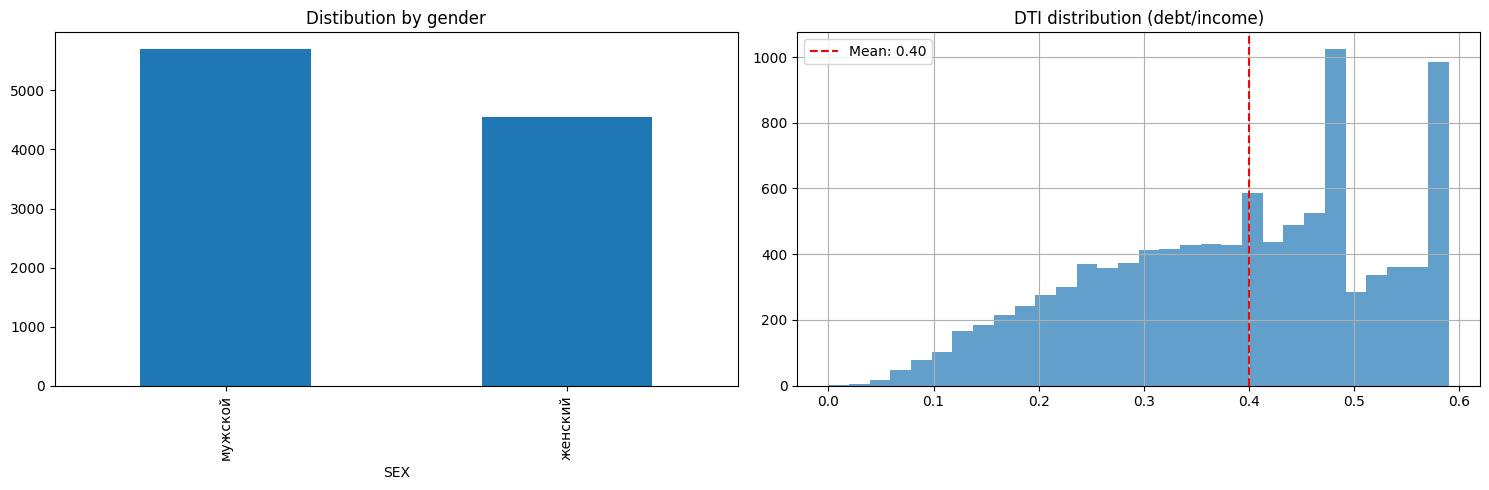

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df_for_segmentation['SEX'].value_counts().plot(kind='bar', ax=ax1, title='Distibution by gender')

df_for_segmentation['DTI'].hist(bins=30, ax=ax2, alpha=0.7)
ax2.set_title('DTI distribution (debt/income)')
ax2.axvline(df_for_segmentation['DTI'].median(), color='red', linestyle='--', label=f'Mean: {df_for_segmentation["DTI"].median():.2f}')
ax2.legend()

plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_for_segmentation.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"{col} coded: {len(le.classes_)} categories")

df_encoded = df_encoded.drop('ID', axis=1)

print(f"\nFinal dataset for segmentation: {df_encoded.shape}")
print("Columns:", df_encoded.columns.tolist())

INCOME_BASE_TYPE coded: 5 categories
CREDIT_PURPOSE coded: 10 categories
SEX coded: 2 categories
EDUCATION coded: 9 categories
EMPL_TYPE coded: 10 categories
EMPL_SIZE coded: 8 categories

Final dataset for segmentation: (10243, 10)
Columns: ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'DTI', 'SEX', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'EDUCATION', 'EMPL_TYPE', 'EMPL_SIZE']


In [9]:
print("Results of data research and preprocessing:")
print(f"Data size: {df_encoded.shape}")
print(f"Gaps: {df_encoded.isnull().sum().sum()}")
print(f"Data types:\n{df_encoded.dtypes}")

Results of data research and preprocessing:
Data size: (10243, 10)
Gaps: 0
Data types:
INCOME_BASE_TYPE           int64
CREDIT_PURPOSE             int64
INSURANCE_FLAG             int64
DTI                      float64
SEX                        int64
FULL_AGE_CHILD_NUMBER      int64
DEPENDANT_NUMBER           int64
EDUCATION                  int64
EMPL_TYPE                  int64
EMPL_SIZE                  int64
dtype: object


In [10]:
print("PART 2\n")


rfm_table_clean = df_for_segmentation.copy()

rfm_table_clean['R'] = rfm_table_clean['DTI']

rfm_table_clean['F'] = rfm_table_clean['FULL_AGE_CHILD_NUMBER'] + rfm_table_clean['DEPENDANT_NUMBER'] + rfm_table_clean['INSURANCE_FLAG']

education_rank = {
    'Не указано': 1, 'среднее': 2, 'среднее-специальное': 3,
    'высшее': 4, 'второе высшее': 5, 'Высшее/Второе высшее/Ученая степень': 6
}
employment_rank = {
    'Не указано': 1, 'рабочий': 2, 'вспомогательный персонал': 3,
    'специалист': 4, 'менеджер среднего звена': 5, 'менеджер высшего звена': 6
}
company_size_rank = {
    'Не указано': 1, '< 50': 2, '>=50': 3, '>=200': 4, '>100': 4, '>250': 5
}

rfm_table_clean['M'] = (
    rfm_table_clean['EDUCATION'].map(education_rank) +
    rfm_table_clean['EMPL_TYPE'].map(employment_rank) +
    rfm_table_clean['EMPL_SIZE'].map(company_size_rank)
)

rfm_table_clean['M'] = rfm_table_clean['M'].fillna(rfm_table_clean['M'].median())

rfm_table_clean['R_Score'] = pd.qcut(rfm_table_clean['R'], q=4, labels=[4, 3, 2, 1])
rfm_table_clean['F_Score'] = pd.qcut(rfm_table_clean['F'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm_table_clean['M_Score'] = pd.qcut(rfm_table_clean['M'], q=4, labels=[1, 2, 3, 4])

def get_clean_rfm_segment(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    total_score = r + f + m

    if total_score >= 11:
        return 'VIP clients'
    elif total_score >= 9:
        return 'Loyal clients'
    elif total_score >= 7:
        return 'Stable clients'
    elif total_score >= 5:
        return 'New clients'
    else:
        return 'Thrifty clients'

rfm_table_clean['RFM_Segment'] = rfm_table_clean.apply(get_clean_rfm_segment, axis=1)

print("RFM-segmentation:")
clean_rfm_counts = rfm_table_clean['RFM_Segment'].value_counts()
for segment, count in clean_rfm_counts.items():
    print(f"{segment}: {count} clients ({count/len(rfm_table_clean)*100:.1f}%)")

PART 2

RFM-segmentation:
Stable clients: 4040 clients (39.4%)
New clients: 2831 clients (27.6%)
Loyal clients: 2297 clients (22.4%)
Thrifty clients: 577 clients (5.6%)
VIP clients: 498 clients (4.9%)


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

rfm_table_clean['KMeans_Cluster'] = clusters

print("K-Means distribution:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} clients ({count/len(clusters)*100:.1f}%)")

K-Means distribution:
Cluster 0: 1387 clients (13.5%)
Cluster 1: 2408 clients (23.5%)
Cluster 2: 2899 clients (28.3%)
Cluster 3: 27 clients (0.3%)
Cluster 4: 3522 clients (34.4%)


In [12]:
final_results = rfm_table_clean.copy()

print(f"Total clients: {len(final_results)}")

print("\nRFM:")
rfm_final = final_results['RFM_Segment'].value_counts()
for segment, count in rfm_final.items():
    print(f"  {segment}: {count} ({count/len(final_results)*100:.1f}%)")

print("\nK-means:")
kmeans_final = final_results['KMeans_Cluster'].value_counts().sort_index()
for cluster, count in kmeans_final.items():
    print(f"  Cluster {cluster}: {count} ({count/len(final_results)*100:.1f}%)")

Total clients: 10243

RFM:
  Stable clients: 4040 (39.4%)
  New clients: 2831 (27.6%)
  Loyal clients: 2297 (22.4%)
  Thrifty clients: 577 (5.6%)
  VIP clients: 498 (4.9%)

K-means:
  Cluster 0: 1387 (13.5%)
  Cluster 1: 2408 (23.5%)
  Cluster 2: 2899 (28.3%)
  Cluster 3: 27 (0.3%)
  Cluster 4: 3522 (34.4%)


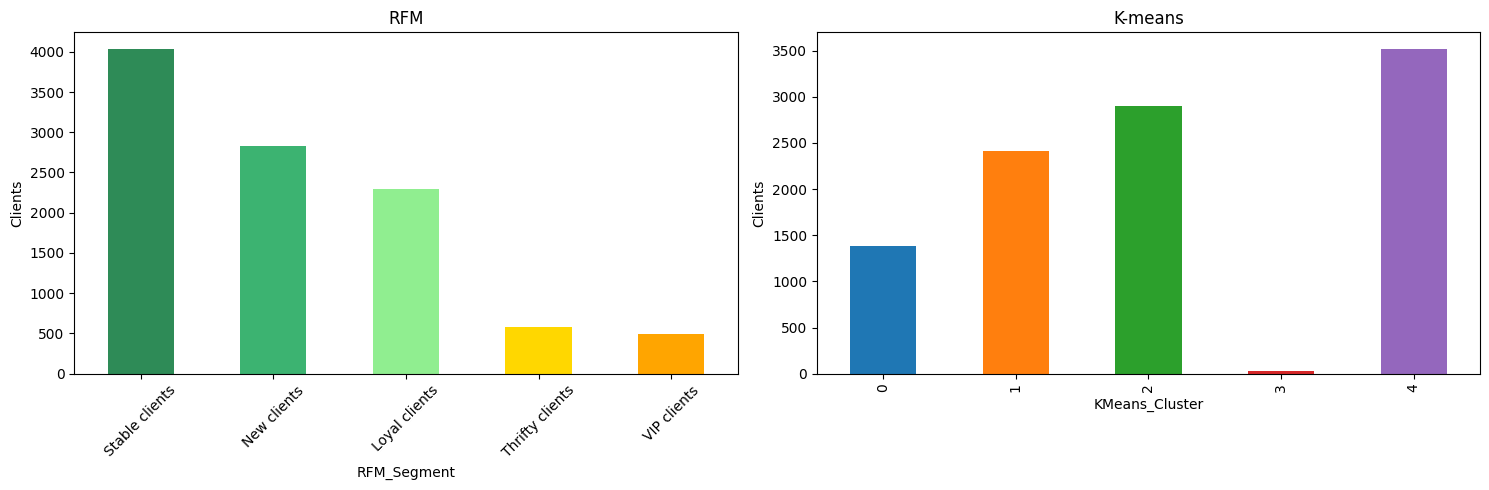

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colors_rfm = ['#2E8B57', '#3CB371', '#90EE90', '#FFD700', '#FFA500']
rfm_final.plot(kind='bar', ax=ax1, color=colors_rfm)
ax1.set_title('RFM')
ax1.set_ylabel('Clients')
ax1.tick_params(axis='x', rotation=45)

colors_kmeans = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
kmeans_final.plot(kind='bar', ax=ax2, color=colors_kmeans)
ax2.set_title('K-means')
ax2.set_ylabel('Clients')

plt.tight_layout()
plt.show()

In [14]:
print("PART 3\n")


from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

k_range = range(2, 11)
results = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(scaled_data, clusters)
    calinski = calinski_harabasz_score(scaled_data, clusters)
    davies = davies_bouldin_score(scaled_data, clusters)

    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies
    })

    print(f"k={k}: Inertia={inertia:.0f}, Silhouette={silhouette:.3f}, Calinski={calinski:.0f}, Davies={davies:.3f}")

results_df = pd.DataFrame(results)
print("\nMetrics table:")
print(results_df.round(3))

PART 3

k=2: Inertia=91881, Silhouette=0.123, Calinski=1176, Davies=2.692
k=3: Inertia=85591, Silhouette=0.113, Calinski=1007, Davies=2.495
k=4: Inertia=77403, Silhouette=0.124, Calinski=1104, Davies=1.982
k=5: Inertia=72761, Silhouette=0.117, Calinski=1044, Davies=1.938
k=6: Inertia=68443, Silhouette=0.109, Calinski=1017, Davies=1.932
k=7: Inertia=64632, Silhouette=0.108, Calinski=998, Davies=1.820
k=8: Inertia=62511, Silhouette=0.105, Calinski=934, Davies=1.698
k=9: Inertia=59970, Silhouette=0.113, Calinski=906, Davies=1.737
k=10: Inertia=58322, Silhouette=0.113, Calinski=860, Davies=1.662

Metrics table:
    k    inertia  silhouette  calinski  davies
0   2  91880.745       0.123  1175.817   2.692
1   3  85590.941       0.113  1007.303   2.495
2   4  77402.871       0.124  1103.546   1.982
3   5  72761.102       0.117  1043.656   1.938
4   6  68442.961       0.109  1016.712   1.932
5   7  64631.743       0.108   997.712   1.820
6   8  62510.505       0.105   933.734   1.698
7   9  59

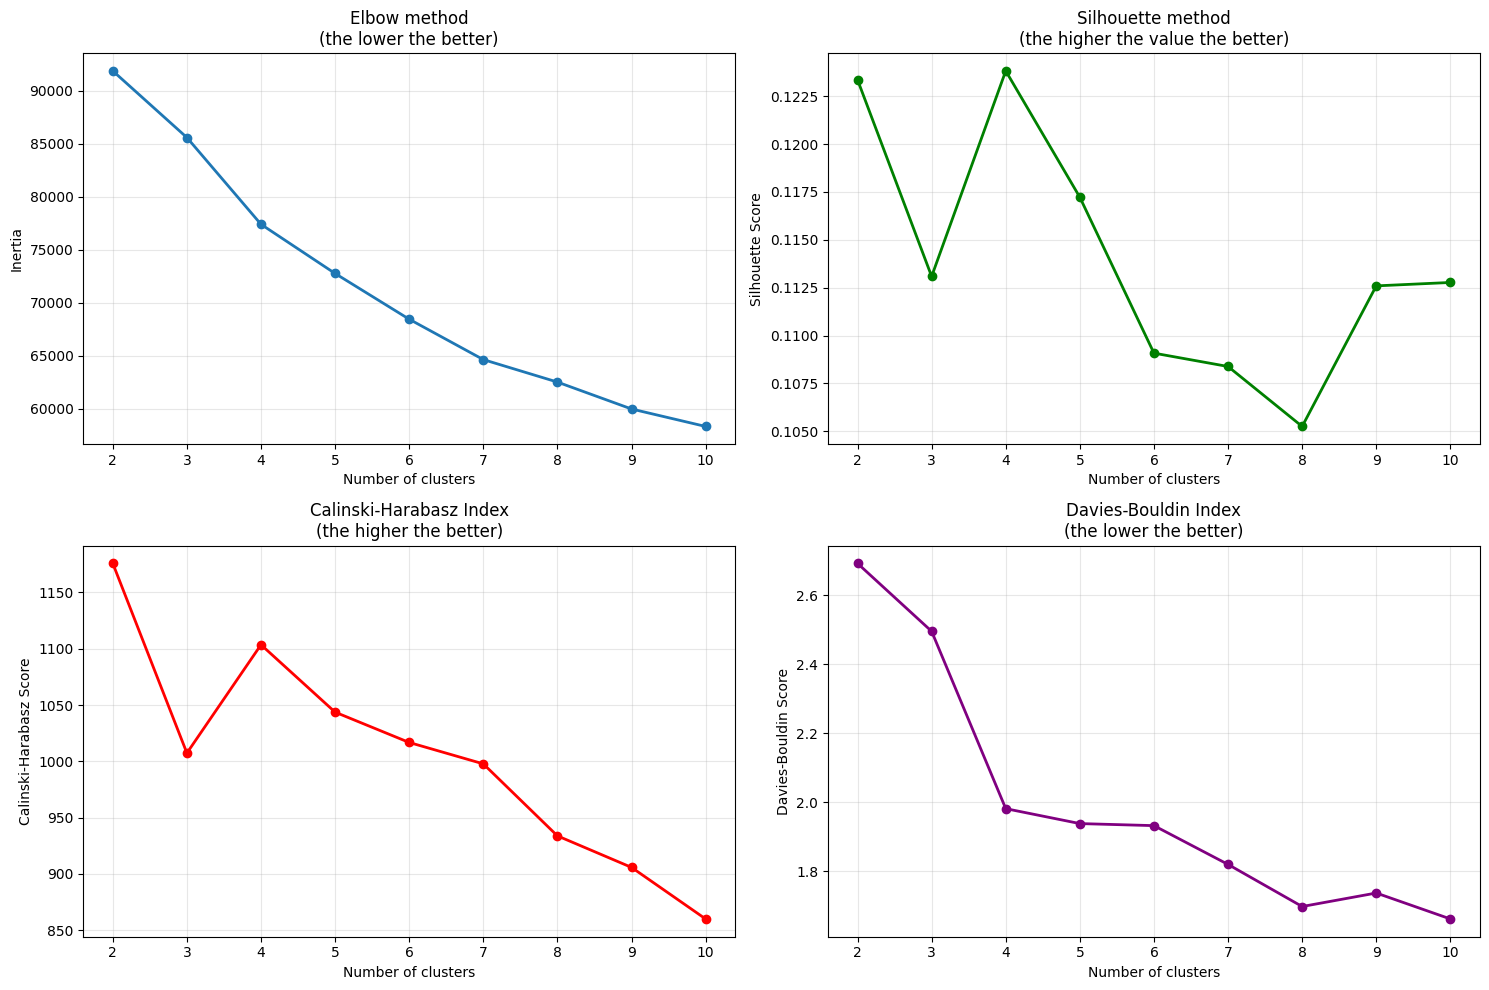

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(results_df['k'], results_df['inertia'], marker='o', linewidth=2)
ax1.set_title('Elbow method\n(the lower the better)')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.grid(True, alpha=0.3)

ax2.plot(results_df['k'], results_df['silhouette'], marker='o', linewidth=2, color='green')
ax2.set_title('Silhouette method\n(the higher the value the better)')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True, alpha=0.3)

ax3.plot(results_df['k'], results_df['calinski'], marker='o', linewidth=2, color='red')
ax3.set_title('Calinski-Harabasz Index\n(the higher the better)')
ax3.set_xlabel('Number of clusters')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.grid(True, alpha=0.3)

ax4.plot(results_df['k'], results_df['davies'], marker='o', linewidth=2, color='purple')
ax4.set_title('Davies-Bouldin Index\n(the lower the better)')
ax4.set_xlabel('Number of clusters')
ax4.set_ylabel('Davies-Bouldin Score')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis of the obtained metrics**

1. Silhouette method:
   - best number of clusters: k=4 (0.124)

2. Calinski-Harabaz:
   - best number of clusters: k=2 (1176)

3. Davies-Bouldin:
   - best number of clusters: k=10 (1.662)

4. Elbow method:
   - After k=5, the decrease slows down

Why did I choose k=5?

First, the task requires a minimum of 5 clusters
Second, at k=5, all metrics show balanced (average) values without “strange" spikes or drops in metric values
Third, more clusters can become statistical noise for training

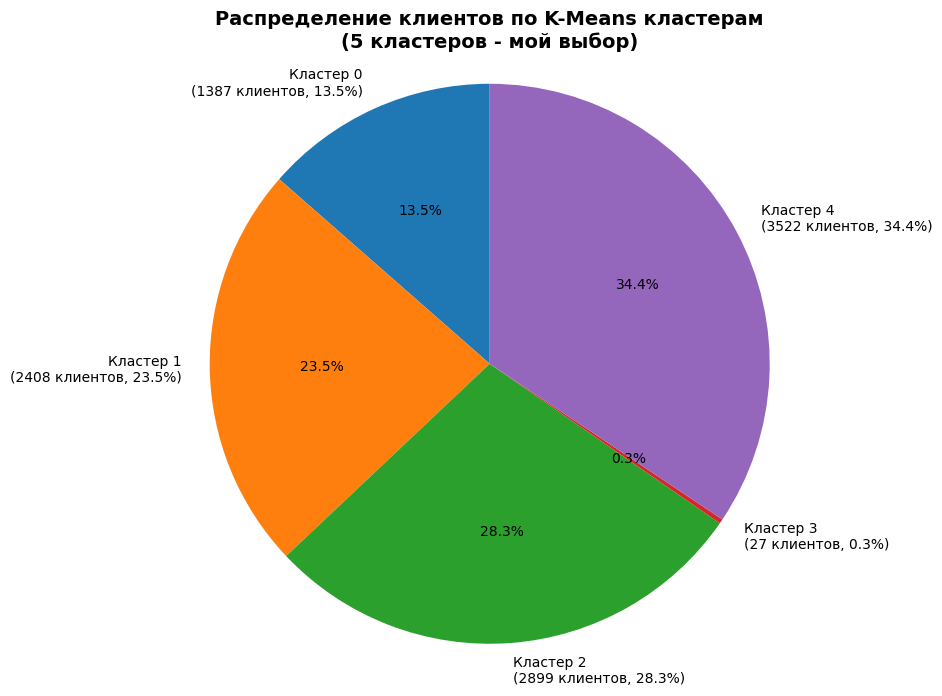

In [85]:
plt.figure(figsize=(10, 8))
plt.pie(kmeans_final.values,
        labels=[f'Cluster {k}\n({v} clients, {v/len(final_results)*100:.1f}%)' for k, v in kmeans_final.items()],
        autopct='%1.1f%%', startangle=90, colors=colors_kmeans)
plt.title('Client distribution using K-Means clustering\n(I chose 5 clusters)',
          fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

In [17]:
print("PART 4\n")


rfm_profiles = final_results.groupby('RFM_Segment').agg({
    'DTI': ['mean', 'std'],
    'FULL_AGE_CHILD_NUMBER': 'mean',
    'DEPENDANT_NUMBER': 'mean',
    'INSURANCE_FLAG': 'mean',
    'SEX': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EDUCATION': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_SIZE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'INCOME_BASE_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'CREDIT_PURPOSE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено'
}).round(3)

rfm_sizes = final_results['RFM_Segment'].value_counts()
rfm_profiles['Размер'] = rfm_sizes
rfm_profiles['%'] = (rfm_sizes / len(final_results) * 100).round(1)

print(rfm_profiles)

PART 4

                   DTI        FULL_AGE_CHILD_NUMBER DEPENDANT_NUMBER  \
                  mean    std                  mean             mean   
RFM_Segment                                                            
Loyal clients    0.299  0.123                 0.913            0.007   
New clients      0.463  0.103                 0.239            0.002   
Stable clients   0.387  0.126                 0.559            0.004   
Thrifty clients  0.527  0.054                 0.050            0.002   
VIP clients      0.232  0.086                 1.402            0.002   

                INSURANCE_FLAG      SEX EDUCATION                EMPL_TYPE  \
                          mean <lambda>  <lambda>                 <lambda>   
RFM_Segment                                                                  
Loyal clients            0.689  мужской    высшее               специалист   
New clients              0.515  мужской    высшее               специалист   
Stable clients           

In [18]:
kmeans_profiles = final_results.groupby('KMeans_Cluster').agg({
    'DTI': ['mean', 'std'],
    'FULL_AGE_CHILD_NUMBER': 'mean',
    'DEPENDANT_NUMBER': 'mean',
    'INSURANCE_FLAG': 'mean',
    'SEX': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EDUCATION': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_SIZE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'INCOME_BASE_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'CREDIT_PURPOSE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено'
}).round(3)

kmeans_sizes = final_results['KMeans_Cluster'].value_counts().sort_index()
kmeans_profiles['Размер'] = kmeans_sizes
kmeans_profiles['%'] = (kmeans_sizes / len(final_results) * 100).round(1)
print(kmeans_profiles)

                  DTI        FULL_AGE_CHILD_NUMBER DEPENDANT_NUMBER  \
                 mean    std                  mean             mean   
KMeans_Cluster                                                        
0               0.383  0.139                 2.152            0.000   
1               0.411  0.137                 0.293            0.000   
2               0.389  0.137                 0.324            0.000   
3               0.399  0.125                 0.370            1.481   
4               0.375  0.133                 0.318            0.000   

               INSURANCE_FLAG      SEX EDUCATION   EMPL_TYPE EMPL_SIZE  \
                         mean <lambda>  <lambda>    <lambda>  <lambda>   
KMeans_Cluster                                                           
0                       0.603  мужской    высшее  специалист      >250   
1                       1.000  женский    высшее  специалист      >250   
2                       1.000  мужской    высшее  специалист 

## RFM segmentation analysis

**Total customers: 10,243**

1. **VIP customers** - 498 customers (4.9%)
   - They have the lowest DTI (0.232) - minimal debt burden
   - Most children (1.4 on average), almost all have higher education
   - 68% insure loans
   - I would describe them as “wealthy family customers”

2. **Loyal customers** - 2,297 customers (22.4%)
   - Low DTI (0.299) - good solvency
   - Medium-high number of children (0.9)
   - 69% insure their loans
   - Let's say they can act as “reliable borrowers”

3. **Stable customers** - 4,040 customers (39.4%)
   - Average DTI (0.387) - moderate debt burden
   - Average number of children (0.56)
   - 65% insure their loans
   - Most ordinary customers

4. **New customers** - 2,831 customers (27.6%)
   - High DTI (0.463) - high debt burden
   - Few children (0.24)
   - Only 52% insure loans
   - Customers with above-average credit burden, younger on average

5. **Economy customers** - 577 customers (5.6%)
   - Highest DTI (0.527) - maximum burden
   - Almost no children (0.05)
   - Only 27% insure loans
   - High-risk borrowers with maximum debt burden

## K-Means Clustering Analysis

**Total customers: 10,243**

1. **Cluster 0** - 1,387 customers (13.5%)
   - Many children (2.15 on average) - a record number
   - Average DTI (0.383) - moderate debt load
   - 60% insure loans
   - The phrase “large families” describes this cluster of customers well

2. **Cluster 1** - 2,408 customers (23.5%)
   - 100% insure loans - a unique characteristic
   - Few children (0.29)
   - High DTI (0.411) - increased debt burden
   - Let's call them “cautious borrowers”

3. **Cluster 2** - 2,899 customers (28.3%)
   - 100% insure loans - also all with insurance
   - Few children (0.32)
   - Average DTI (0.389) - moderate burden
   - These are responsible ordinary (by ordinary I mean average) customers

4. **Cluster 3** - 27 customers (0.3%)
   - Unique: 1.48 dependents on average
   - Only 44% insure loans
   - Average DTI (0.399)
   - Special group - customers with dependents

5. **Cluster 4** - 3,522 customers (34.4%)
   - 0% insure loans - no one insures
   - Few children (0.32)
   - Low DTI (0.375) - minimal burden
   - Thrifty borrowers who avoid additional expenses

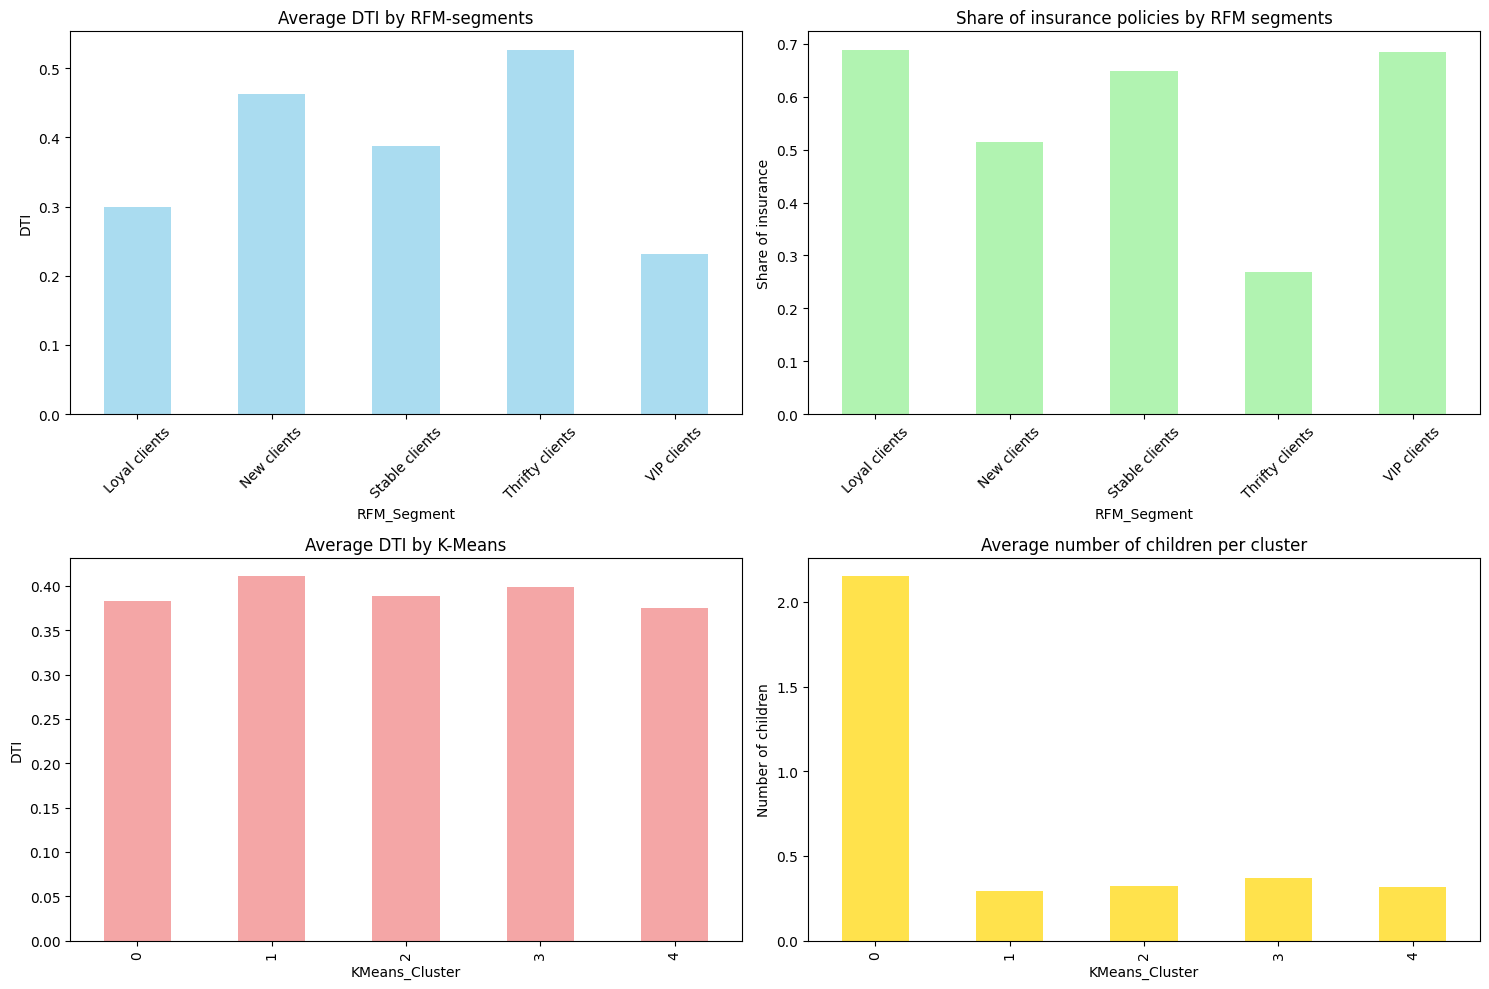

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

rfm_profiles[('DTI', 'mean')].plot(kind='bar', ax=axes[0,0], color='skyblue', alpha=0.7)
axes[0,0].set_title('Average DTI by RFM-segments')
axes[0,0].set_ylabel('DTI')
axes[0,0].tick_params(axis='x', rotation=45)

rfm_profiles[('INSURANCE_FLAG', 'mean')].plot(kind='bar', ax=axes[0,1], color='lightgreen', alpha=0.7)
axes[0,1].set_title('Share of insurance policies by RFM segments')
axes[0,1].set_ylabel('Share of insurance')
axes[0,1].tick_params(axis='x', rotation=45)

kmeans_profiles[('DTI', 'mean')].plot(kind='bar', ax=axes[1,0], color='lightcoral', alpha=0.7)
axes[1,0].set_title('Average DTI by K-Means')
axes[1,0].set_ylabel('DTI')

kmeans_profiles[('FULL_AGE_CHILD_NUMBER', 'mean')].plot(kind='bar', ax=axes[1,1], color='gold', alpha=0.7)
axes[1,1].set_title('Average number of children per cluster')
axes[1,1].set_ylabel('Number of children')

plt.tight_layout()
plt.show()